## Sandbox

- https://towardsdatascience.com/how-to-make-a-pytorch-transformer-for-time-series-forecasting-69e073d4061e
- https://github.com/KasperGroesLudvigsen/influenza_transformer/blob/main/sandbox.py

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.6.22</div>
<div style="text-align: right"> Last update: 2023.11.02</div>

In [1]:
import datetime
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline
# print(plt.stype.available)

# Options for pandas
pd.options.display.max_columns = 30

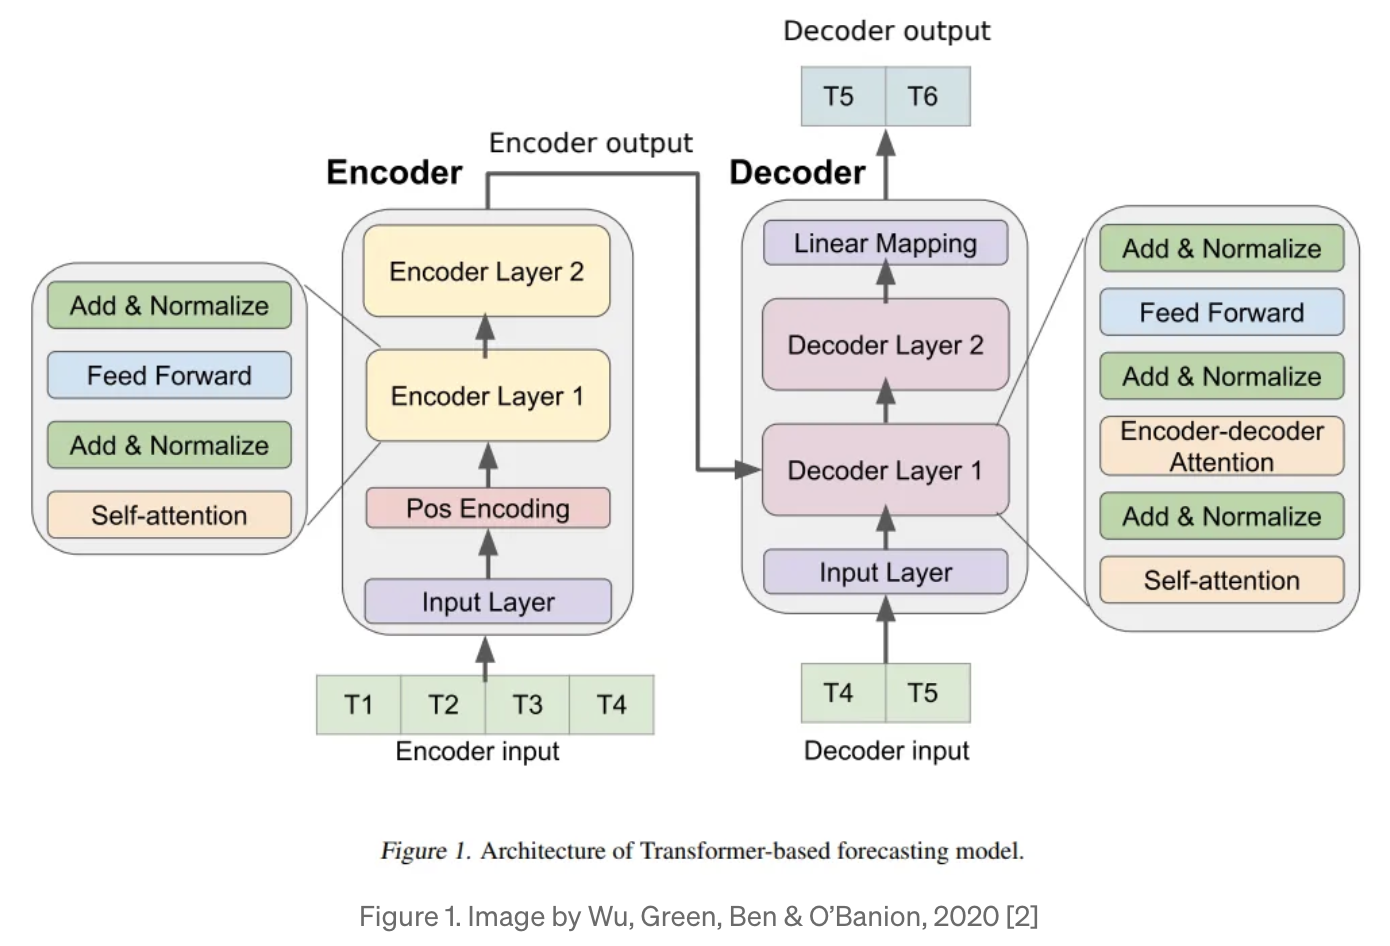

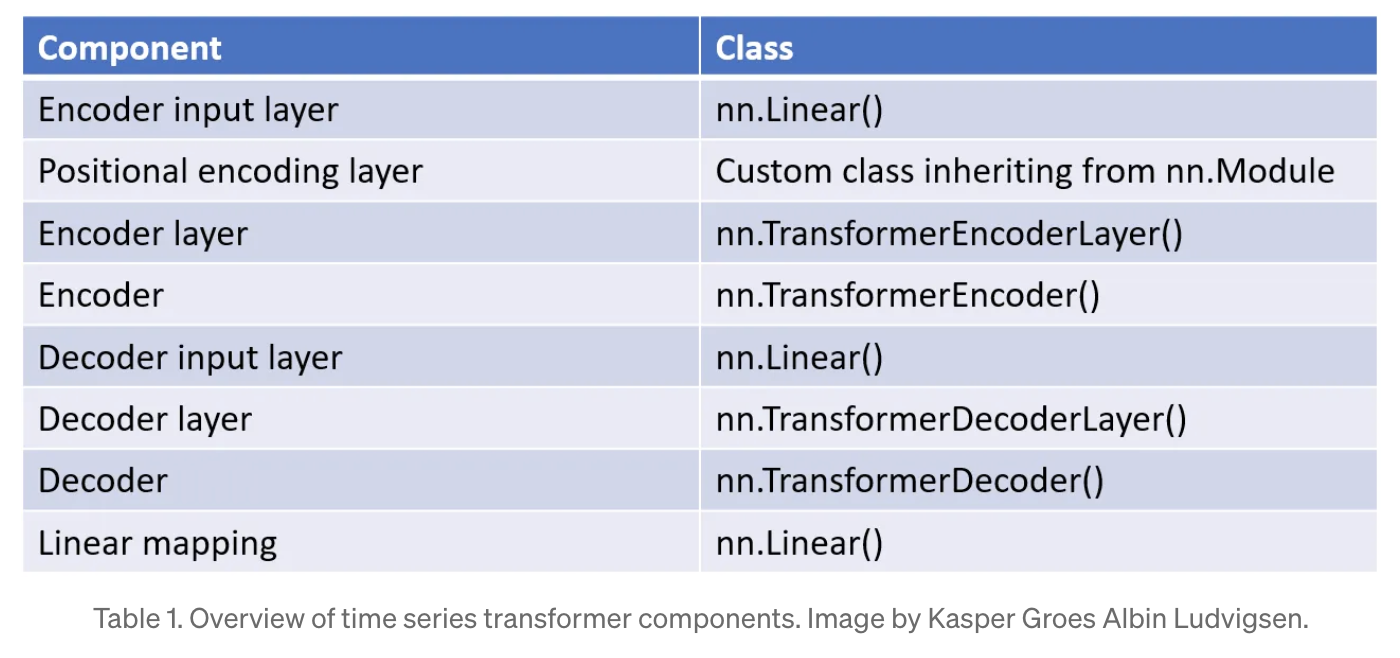

In [2]:
import dataset as ds
import utils
from torch.utils.data import DataLoader
import torch
import datetime
import transformer as tst
import numpy as np

In [3]:
# Hyperparams
test_size = 0.1
batch_size = 128
target_col_name = "FCR_N_PriceEUR"
timestamp_col = "timestamp"
# Only use data from this date and onwards
cutoff_date = datetime.datetime(2017, 1, 1) 

In [4]:
## Params
dim_val = 512
n_heads = 8
n_decoder_layers = 4
n_encoder_layers = 4
dec_seq_len = 92 # length of input given to decoder
enc_seq_len = 153 # length of input given to encoder
output_sequence_length = 48 # target sequence length. If hourly data and length = 48, you predict 2 days ahead
window_size = enc_seq_len + output_sequence_length # 201
step_size = 1 # Step size, i.e. how many time steps does the moving window move at each step
in_features_encoder_linear_layer = 2048
in_features_decoder_linear_layer = 2048
max_seq_len = enc_seq_len
batch_first = False

In [5]:
# Define input variables 
exogenous_vars = [] # should contain strings. Each string must correspond to a column name
input_variables = [target_col_name] + exogenous_vars
target_idx = 0 # index position of target in batched trg_y

In [6]:
input_size = len(input_variables)
input_size

1

In [7]:
# read data
data = utils.read_data(timestamp_col_name=timestamp_col)
display(data.head())
print(data.shape)

Reading file in data/dfs_merged_upload.csv


,Unnamed: 0,FCR_N_PriceEUR
timestamp,,
2017-01-01 00:00:00+00:00,0,62.130001
2017-01-01 01:00:00+00:00,1,62.080002
2017-01-01 02:00:00+00:00,2,62.070000
2017-01-01 03:00:00+00:00,3,62.009998
2017-01-01 04:00:00+00:00,4,61.900002


(45985, 2)


In [8]:
# Read data
training_data = data[: -(round(len(data)*test_size))]
training_data.shape

(41387, 2)

In [9]:
# Make list of (start_idx, end_idx) pairs that are used to slice the time series sequence into chunkc. 
# Should be training data indices only
training_indices = utils.get_indices_entire_sequence(
    data= training_data,
    window_size=window_size, # 201,
    step_size=step_size
)

In [10]:
training_indices

[(0, 201),
 (1, 202),
 (2, 203),
 (3, 204),
 (4, 205),
 (5, 206),
 (6, 207),
 (7, 208),
 (8, 209),
 (9, 210),
 (10, 211),
 (11, 212),
 (12, 213),
 (13, 214),
 (14, 215),
 (15, 216),
 (16, 217),
 (17, 218),
 (18, 219),
 (19, 220),
 (20, 221),
 (21, 222),
 (22, 223),
 (23, 224),
 (24, 225),
 (25, 226),
 (26, 227),
 (27, 228),
 (28, 229),
 (29, 230),
 (30, 231),
 (31, 232),
 (32, 233),
 (33, 234),
 (34, 235),
 (35, 236),
 (36, 237),
 (37, 238),
 (38, 239),
 (39, 240),
 (40, 241),
 (41, 242),
 (42, 243),
 (43, 244),
 (44, 245),
 (45, 246),
 (46, 247),
 (47, 248),
 (48, 249),
 (49, 250),
 (50, 251),
 (51, 252),
 (52, 253),
 (53, 254),
 (54, 255),
 (55, 256),
 (56, 257),
 (57, 258),
 (58, 259),
 (59, 260),
 (60, 261),
 (61, 262),
 (62, 263),
 (63, 264),
 (64, 265),
 (65, 266),
 (66, 267),
 (67, 268),
 (68, 269),
 (69, 270),
 (70, 271),
 (71, 272),
 (72, 273),
 (73, 274),
 (74, 275),
 (75, 276),
 (76, 277),
 (77, 278),
 (78, 279),
 (79, 280),
 (80, 281),
 (81, 282),
 (82, 283),
 (83, 284),
 (

In [11]:
training_data = ds.TransformerDataset(
    data = torch.tensor(training_data[input_variables].values).float(),
    indices = training_indices,
    enc_seq_len=enc_seq_len, #153 ,인코더 입력길이
    dec_seq_len=dec_seq_len, #92 , 디코더 입력길이
    target_seq_len=output_sequence_length # 48 , 타겟 길이, 2일간 예측
)

From get_src_trg: data size = torch.Size([41387, 1])


In [12]:
print(training_data.__getitem__(1)[0].shape) # 인코더 입력
print(training_data.__getitem__(1)[1].shape) # 디코더 입력
print(training_data.__getitem__(1)[2].shape) # 타겟 길이

torch.Size([153, 1])
torch.Size([48, 1])
torch.Size([48])


In [13]:
# Making dataloader
training_data = DataLoader(training_data, batch_size)

In [14]:
i, batch = next(enumerate(training_data))
src, trg, trg_y = batch

print(src.shape)
print(trg.shape)
print(trg_y.shape)

torch.Size([128, 153, 1])
torch.Size([128, 48, 1])
torch.Size([128, 48])


In [15]:
# Permute from shape [batch size, seq len, num features] to [seq len, batch size, num features]
if batch_first == False:

    shape_before = src.shape
    src = src.permute(1, 0, 2)
    print("src shape changed from {} to {}".format(shape_before, src.shape))

    shape_before = trg.shape
    trg = trg.permute(1, 0, 2)
    print("trg shape changed from {} to {}".format(shape_before, trg.shape))


src shape changed from torch.Size([128, 153, 1]) to torch.Size([153, 128, 1])
trg shape changed from torch.Size([128, 48, 1]) to torch.Size([48, 128, 1])


In [16]:
model = tst.TimeSeriesTransformer(
    input_size=len(input_variables),
    dec_seq_len=enc_seq_len,
    batch_first=batch_first,
    num_predicted_features=1
    )

In [17]:
model

TimeSeriesTransformer(
  (encoder_input_layer): Linear(in_features=1, out_features=512, bias=True)
  (decoder_input_layer): Linear(in_features=1, out_features=512, bias=True)
  (linear_mapping): Linear(in_features=512, out_features=1, bias=True)
  (positional_encoding_layer): PositionalEncoder(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout

In [18]:
# Make src mask for decoder with size:
# [batch_size*n_heads, output_sequence_length, enc_seq_len]
src_mask = utils.generate_square_subsequent_mask(
    dim1=output_sequence_length, # 48
    dim2=enc_seq_len # 153
    )

# Make tgt mask for decoder with size:
# [batch_size*n_heads, output_sequence_length, output_sequence_length]
tgt_mask = utils.generate_square_subsequent_mask( 
    dim1=output_sequence_length,
    dim2=output_sequence_length
    )

In [19]:
print(src_mask.shape)
print(tgt_mask.shape)

torch.Size([48, 153])
torch.Size([48, 48])


In [20]:
output = model(
    src=src,
    tgt=trg,
    src_mask=src_mask,
    tgt_mask=tgt_mask
    )

In [21]:
output.shape

torch.Size([48, 128, 1])

In [22]:
src.shape

torch.Size([153, 128, 1])

In [23]:
trg.shape

torch.Size([48, 128, 1])

In [24]:
from torchinfo import summary

In [25]:
summary(
    model,
    input_size = [(153, 128, 1), (48, 128, 1), (48, 153), (48, 48)]
)

Layer (type:depth-idx)                        Output Shape              Param #
TimeSeriesTransformer                         [48, 128, 1]              --
├─Linear: 1-1                                 [153, 128, 512]           1,024
├─PositionalEncoder: 1-2                      [153, 128, 512]           --
│    └─Dropout: 2-1                           [153, 128, 512]           --
├─TransformerEncoder: 1-3                     [153, 128, 512]           --
│    └─ModuleList: 2-2                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [153, 128, 512]           3,152,384
│    │    └─TransformerEncoderLayer: 3-2      [153, 128, 512]           3,152,384
│    │    └─TransformerEncoderLayer: 3-3      [153, 128, 512]           3,152,384
│    │    └─TransformerEncoderLayer: 3-4      [153, 128, 512]           3,152,384
├─Linear: 1-4                                 [48, 128, 512]            1,024
├─TransformerDecoder: 1-5                     [48, 128, 512] 